In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
datapath = '/content/drive/MyDrive/Niloy_work_data_collection  - Sheet1.csv'
df = pd.read_csv(datapath)
df.head()

,Text,Category
0,আপেল ঠিক কালো মানুষদের মত তারা গাছ থেকে ঝুলন্ত...,coRAC
1,শুধুমাত্র সত্যিকারের শ্বেতাঙ্গ খ্রিস্টান আমেরি...,coRAC
2,মিয়ানমার দেশ মানে কুলংগার এবং ঘৃনিত দেশ,geoRAC
3,ওই ফকিরের কালো পোলা আমাদের সাথে খেতে পারবে না,coRAC
4,আমি একজন বর্ণবাদী হয়ে জন্মেছি এবং আমি একজন বর...,coRAC


<Axes: xlabel='Category'>

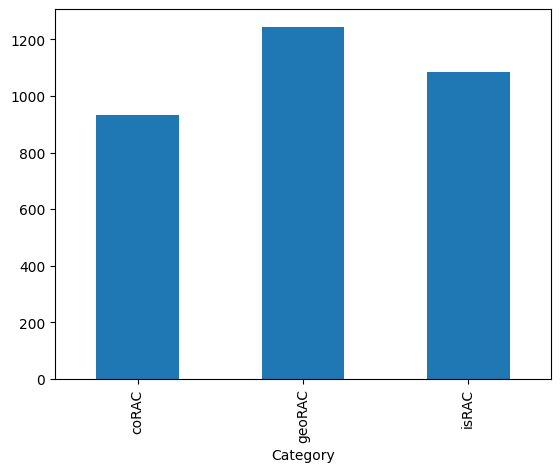

In [ ]:
df.groupby(['Category']).size().plot.bar()

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.8 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

example_text = 'আমি তাকে মেরে ফেলবো'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10,
                       truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])


tensor([[  101,   938, 37376, 51003, 39893, 30806,   969, 42620, 19910,   102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [ ]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] আমি তাকে মেরে ফেলব [SEP]


In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
labels = {'coRAC':0,
          'geoRAC':1,
          'isRAC':2,
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['Category']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

2611 326 327


In [ ]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:

from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

def train(model, train_data, val_data, test_data,learning_rate, epochs):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            model.eval()
            test_labels = []
            test_preds = []
            with torch.no_grad():
                for test_input, test_label in test_dataloader:
                    test_labels += test_label.tolist()
                    test_label = test_label.to(device)
                    mask = test_input['attention_mask'].to(device)
                    input_id = test_input['input_ids'].squeeze(1).to(device)
                    output = model(input_id, mask)
                    preds = output.argmax(dim=1).tolist()
                    test_preds += preds
            precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
            print(f'Test Precision: {precision:.4f} | Test Recall: {recall:.4f} | Test F1 Score: {f1_score:.4f}')


EPOCHS = 7
model = BertClassifier()
LR = 1e-6

train(model, df_train, df_val,df_test ,LR, EPOCHS)



"""
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

def train(model, train_data, val_data, test_data, learning_rate, epochs):

    # create dataloaders for training, validation, and test sets
    train, val ,test= Dataset(train_data), Dataset(val_data),Dataset(test_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)



    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # create optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    for epoch_num in range(epochs):

        # training loop
         for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

        # test loop
        model.eval()
        test_labels = []
        test_preds = []
        with torch.no_grad():
            for test_input, test_label in test_dataloader:
                test_labels += test_label.tolist()
                test_label = test_label.to(device)
                mask = test_input['attention_mask'].to(device)
                input_id = test_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)
                preds = output.argmax(dim=1).tolist()
                test_preds += preds
        precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
        print(f'Test Precision: {precision:.4f} | Test Recall: {recall:.4f} | Test F1 Score: {f1_score:.4f}')

        # update model parameters

"""


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1306/1306 [05:08<00:00,  4.23it/s]


Epochs: 1 | Train Loss:  0.456                 | Train Accuracy:  0.709                 | Val Loss:  0.176                 | Val Accuracy:  0.939
Test Precision: 0.9300 | Test Recall: 0.9297 | Test F1 Score: 0.9294


100%|██████████| 1306/1306 [05:10<00:00,  4.21it/s]


Epochs: 2 | Train Loss:  0.100                 | Train Accuracy:  0.960                 | Val Loss:  0.094                 | Val Accuracy:  0.951
Test Precision: 0.9638 | Test Recall: 0.9633 | Test F1 Score: 0.9632


100%|██████████| 1306/1306 [05:09<00:00,  4.22it/s]


Epochs: 3 | Train Loss:  0.047                 | Train Accuracy:  0.981                 | Val Loss:  0.074                 | Val Accuracy:  0.957
Test Precision: 0.9518 | Test Recall: 0.9511 | Test F1 Score: 0.9511


100%|██████████| 1306/1306 [05:09<00:00,  4.22it/s]


Epochs: 4 | Train Loss:  0.025                 | Train Accuracy:  0.990                 | Val Loss:  0.078                 | Val Accuracy:  0.963
Test Precision: 0.9731 | Test Recall: 0.9725 | Test F1 Score: 0.9724


100%|██████████| 1306/1306 [05:09<00:00,  4.22it/s]


Epochs: 5 | Train Loss:  0.013                 | Train Accuracy:  0.997                 | Val Loss:  0.063                 | Val Accuracy:  0.969
Test Precision: 0.9663 | Test Recall: 0.9664 | Test F1 Score: 0.9663


100%|██████████| 1306/1306 [05:09<00:00,  4.21it/s]


Epochs: 6 | Train Loss:  0.009                 | Train Accuracy:  0.998                 | Val Loss:  0.093                 | Val Accuracy:  0.957
Test Precision: 0.9636 | Test Recall: 0.9633 | Test F1 Score: 0.9633


100%|██████████| 1306/1306 [05:09<00:00,  4.21it/s]


Epochs: 7 | Train Loss:  0.006                 | Train Accuracy:  0.998                 | Val Loss:  0.079                 | Val Accuracy:  0.966
Test Precision: 0.9695 | Test Recall: 0.9694 | Test F1 Score: 0.9694


'\nfrom torch.optim import Adam\nfrom tqdm import tqdm\nfrom sklearn.metrics import precision_recall_fscore_support\n\ndef train(model, train_data, val_data, test_data, learning_rate, epochs):\n\n    # create dataloaders for training, validation, and test sets\n    train, val ,test= Dataset(train_data), Dataset(val_data),Dataset(test_data)\n    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)\n    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)\n    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)\n\n\n\n    use_cuda = torch.cuda.is_available()\n    device = torch.device("cuda" if use_cuda else "cpu")\n\n    # create optimizer and loss function\n    criterion = nn.CrossEntropyLoss()\n    optimizer = Adam(model.parameters(), lr=learning_rate)\n\n    for epoch_num in range(epochs):\n\n        # training loop\n         for epoch_num in range(epochs):\n\n            total_acc_train = 0\n            total_loss_train = 0\n\n  

In [ ]:
labels = {'coRAC': 0, 'geoRAC': 1,'isRAC':2}
inv_labels = {v: k for k, v in labels.items()}

# evaluate on test set and get individual metrics for each class
test = Dataset(df_test)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
test_labels = []
test_preds = []
with torch.no_grad():
    for test_input, test_label in test_dataloader:
        test_labels += test_label.tolist()
        test_label = test_label.to(device)
        mask = test_input['attention_mask'].to(device)
        input_id = test_input['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask)
        preds = output.argmax(dim=1).tolist()
        test_preds += preds

precision, recall, f1_score, support = precision_recall_fscore_support(test_labels, test_preds, labels=list(labels.values()), average=None)

# print individual metrics for each class
for i, label in inv_labels.items():
    print(f"Metrics for {label}:")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1_score[i]:.4f}")
    print(f"Support: {support[i]}")
#This code first defines the mapping between the class labels and their corresponding indices, and then uses precision_recall_fscore_support with labels=list(labels.values()) and average=None to get the individual metrics for each class. Finally, it prints the metrics for each class using the inv_labels dictionary to map the indices back to their original labels.








Metrics for coRAC:
Precision: 0.9747
Recall: 0.9872
F1-score: 0.9809
Support: 78
Metrics for geoRAC:
Precision: 0.9627
Recall: 0.9773
F1-score: 0.9699
Support: 132
Metrics for isRAC:
Precision: 0.9737
Recall: 0.9487
F1-score: 0.9610
Support: 117


In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

evaluate(model, df_test)

Test Accuracy:  0.969


#Confusion Matrix
